[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [ ]:
import os, getpass, sys
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
import langchain_core
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from typing import Dict, List, Union, Literal
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display


#Import API Keys(storing them all in a seperate file so i run into less issues with git)
_root = "/home/zjc1002/Mounts/code/"
_langsmith_trace = 'true'
_langsmith_project = 'zjc_custom_v1'
_anthropic_model = 'claude-3-haiku-20240307'
_temparate = 0
_max_tokens = 4000
_streaming = True
_system_message = None
_db_path = "/home/zjc1002/Mounts/data/langgraph_memory/state_db/example1.db"
# This is a basic config to enable tracing of conversations and  utilization of memory
_config = {'configurable': {'thread_id':"1"}}

# Custom functions
sys.path.append(_root)
from  admin.api_keys import _api_keys
from admin.sys_ops import _set_env
from langgraph_projects.tools import get_weather, get_date, multiply, add, divide , internet_search

# This anthropic and internet tool requires  API key to be set as a environment variable(s)
for api_key in ["TAVILY_API_KEY","ANTHROPIC_API_KEY",'OPENAI_API_KEY','LANGSMITH_API_KEY']:
    _set_env(api_key
            ,value =  _api_keys[api_key])

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [ ]:
# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}. Only output the list of sub-topics, no additional information and do not include the overall topic in the list. The list must be only 3 elements long"""

#this prompt is used to generate a joke about a specific subject(subtopic)
joke_prompt = """Generate a joke about {subject}"""

best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model =  ChatAnthropic(
    model=_anthropic_model,
    temperature=_temparate,
    #max_tokens=_max_tokens,
    #streaming=_streaming,
    verbose=True,
)

### E2E (Will break workflow out piece by piece later)

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from IPython.display import Image
from langgraph.graph import END, StateGraph, START
from langgraph.constants import Send
from pydantic import field_validator

class Subjects(BaseModel):
    subjects: list[str]
    
    @field_validator('subjects')
    def validate_subjects_length(cls, v):
        if len(v) != 3:
            raise ValueError('subjects must contain exactly 3 elements')
        return v

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str
    subjects_prompt: str
    joke_prompt: str
    best_joke_prompt: str

#TOPIC GENERATION GRAPH
#NOTE: with_structured_output used to enforce the output of the model to be a specific type
def generate_topics(state: OverallState):
    
    prompt = state['subjects_prompt'].format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
   
    #return response key aligned to the Subjects model and the overall state
    return {"subjects": response.subjects}

# Parllell generation of jokes for each subject using send()
def continue_to_jokes(state: OverallState):
    return [Send(
        "generate_joke"
            , {"subject": s
            , "joke_prompt":state['joke_prompt']
            }
           ) for s in state["subjects"]]


class JokeState(TypedDict):
    subject: str
    joke_prompt: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = state['joke_prompt'].format(subject=state["subject"])

    #enforce  joke output to be a string
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


def best_joke(state: OverallState):

    #jokes in annotated list generated from  each parallel joke generation
    jokes = "\n\n".join(state["jokes"])
    
    prompt = state['best_joke_prompt'].format(topic=state["topic"], jokes=jokes)

    # enforce best joke output to be an integer ID
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


#build the graph 
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")

#pass topics to SEND() via continue_to_jokes mapper function, and then use the SEND() function to pass each subject to the generate_joke node
graph.add_conditional_edges(
    "generate_topics"
    , continue_to_jokes
    , ["generate_joke"])

# pass the list of  jokes generated to the best_joke node
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())


## Call the graph: here we call it to generate a list of jokes
for s in app.stream(
    {"topic": "colors in rainbow"
      , 'subjects_prompt': subjects_prompt
      , 'joke_prompt': joke_prompt
      , 'best_joke_prompt': best_joke_prompt
      }):
    print(s)

{'generate_topics': {'subjects': ['red', 'orange', 'yellow']}}
{'generate_joke': {'jokes': ['Why was the tomato red? Because it saw the salad dressing!']}}
{'generate_joke': {'jokes': ["Why did the orange go to the doctor? Because it wasn't peeling well!"]}}
{'generate_joke': {'jokes': ['Why was the math book sad? Because it had too many problems!']}}
{'best_joke': {'best_selected_joke': 'Why was the tomato red? Because it saw the salad dressing!'}}


## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [40]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str
    subjects_prompt: str
    joke_prompt: str
    best_joke_prompt: str

Generate subjects for jokes.

In [42]:
#zjc
def generate_topics(state: OverallState):
    
    prompt = state['subjects_prompt'].format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
   
    #return response key aligned to the Subjects model and the overall state
    return {"subjects": response.subjects}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [43]:
from langgraph.constants import Send

def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s, "joke_prompt":state['joke_prompt']}
                 ) for s in state["subjects"]]
# #zjc
# def continue_to_jokes(state: OverallState):

#     #NOTE: generate_joke is a function that will be defined later to dictate instructions for joke generation
#     return [Send("generate_joke"
#                  , {"subject": s
#                     ,"joke_prompt":state['joke_prompt']
#                     }
#                  ) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [45]:
class JokeState(TypedDict):
    subject: str
    joke_prompt: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = state['joke_prompt'].format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [46]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

# #zjc 
# def best_joke(state: OverallState):
#     jokes = "\n\n".join(state["jokes"]) #generated by generate_joke function
#     prompt = state['best_joke_prompt'].format(topic=state["topic"], jokes=jokes) #identify the best  joke from the list of jokes
#     response = model.with_structured_output(BestJoke).invoke(prompt)

#     # Return the best joke ID in a format that matches the BestJoke model and the overall state
#     return {"best_selected_joke": state["jokes"][response.id]}

## Compile

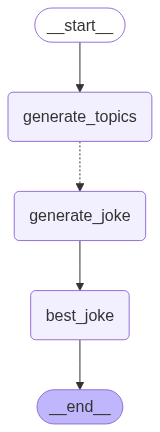

In [47]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_topics")

#pass topics to SEND() via continue_to_jokes mapper function, and then use the SEND() function to pass each subject to the generate_joke node
graph.add_conditional_edges(
    "generate_topics"
    , continue_to_jokes
    , ["generate_joke"])

# pass the list of  jokes generated to the best_joke node
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [48]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream(
    {"topic": "animals"
      , 'subjects_prompt': subjects_prompt
      , 'joke_prompt': joke_prompt
      , 'best_joke_prompt': best_joke_prompt
      }):
    print(s)

{'generate_topics': {'subjects': ['pets', 'wildlife', 'zoology']}}
{'generate_joke': {'jokes': ['Why did the cat go to the vet? Because it was feline a little sick!']}}
{'generate_joke': {'jokes': ['Why did the bear go into the forest? Because it wanted to find the bear necessities!']}}
{'generate_joke': {'jokes': ['Why did the zoologist cross the road? To get to the other side and study the animals there!']}}
{'best_joke': {'best_selected_joke': 'Why did the cat go to the vet? Because it was feline a little sick!'}}


## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.